# Predicting Housing Prices with the Ames Dataset

<h3>Task at Hand:</h3><br>
<strong>Using the Ames housing dataset, predict 'SalePrice' based on a number of characteristics about the house. Predict with an accuracy of .15 (RMSE) using a linear regression model.</strong>

## Step 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')
%matplotlib inline

style.use('seaborn')

pd.options.display.max_columns = None

## Step 2. Get the data

In [2]:
train_original = pd.read_csv("../data/raw/train.csv")
test_original = pd.read_csv("../data/raw/test.csv")

In [3]:
train_original.shape

(1460, 81)

In [4]:
test_original.shape

(1459, 80)

## Step 3. Feature Engineering

### Step 3a. Inspect (and transform) the target variable, 'SalePrice'.

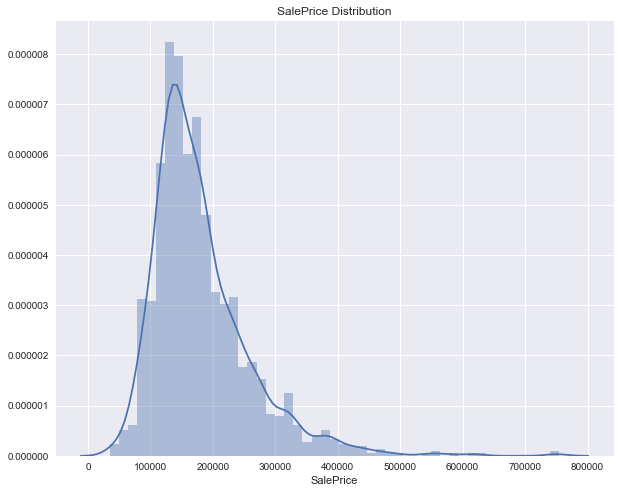

In [5]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(train_original['SalePrice'])
ax.set_title('SalePrice Distribution');

This is right skewed.  We can apply the 'log1p' tranformation to help better distribute the data.

In [6]:
# Before we start modifying data, make a copy to leave "originals" intact.
train = train_original.copy()
test = test_original.copy()

In [7]:
# Apply the transformation to our working DataFrame.
train['SalePrice'] = np.log1p(train['SalePrice'])

Text(0.5,1,'SalePrice Distribution after log1p')

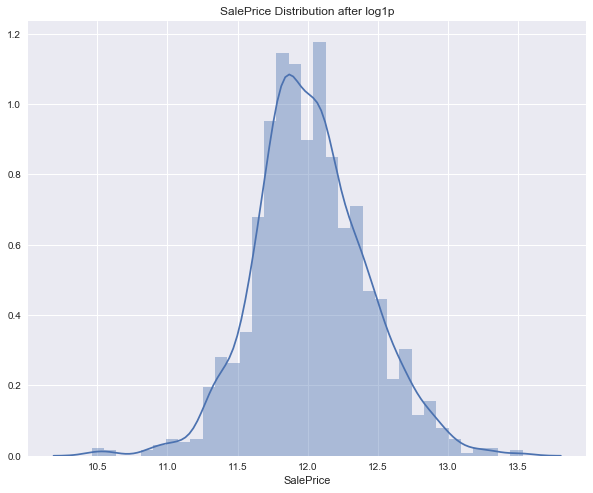

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(train['SalePrice'])
ax.set_title('SalePrice Distribution after log1p')

This looks better.

### Step 3b. Feature Selection: First Pass

This dataset has eighty features, which is a bit overwhelming. First, I will go through each feature to determine the following:<br><br>
1) <strong>Intuition:</strong> Does this feature seem relavant on an intuitive level?<br>
2) <strong>Correlation:</strong> Does the feature seem to have any correlation with our target value, SalePrice?<br>
3) <strong>Redundancy:</strong> Does the feature indicate roughly the same thing as another feature?<br>
4) <strong>Distribution:</strong> Does the feature have a relatively normal distribution if continuous? If categorical, how does the data break down?  For example, are there only a few rows that have a certain Porch property?<br>
5) <strong>Outliers:</strong> Does the data have a lot of outliers?<br>
6) <strong>Nulls:</strong> Are there a lot of null values? How will we deal with them?<br>
7) <strong>Encoding:</strong> If categorical, can we easily encode the values without adding too many columns?<br><br>
Here, I determine whether or not to include a few features based on the above thought process.<br><br>
<i>Note: I use Google Sheets to keep track of the characteristics of the features.</i>

#### Some useful analysis functions before getting started:

In [9]:
def cat_inspect(df, independent):
    """Provides distribution data for an independent variable 
    and an independent/SalePrice correlation visualization
    (for categorical variables).
    """
    print("Value Counts\n{0}".format(df[independent].value_counts()))
    ax = sns.boxplot(df[independent], df['SalePrice'])
    ax.set_title(independent)
    
def cont_inspect(df, independent):
    """Provides distribution data for an independent variable 
    and an independent/SalePrice correlation visualization
    (for categorical variables).
    """
    print("Number of NaNs: {0}".format(df[independent].isnull().sum()))
    ax1 = sns.scatterplot(x=df[independent], y=df['SalePrice'])
    ax1.set_title("{0} vs. SalePrice".format(independent))
    ax1 = plt.figure();
    ax2 = sns.distplot(df[independent])
    ax2.set_title("{0} Distribution".format(independent))
    ax2 = plt.figure();

#### Example 1: OverallQual (Categorical)

Value Counts
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64


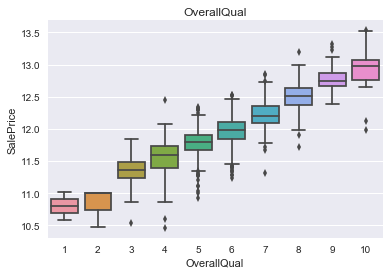

In [10]:
cat_inspect(train, 'OverallQual')

#### Example 2: GrLivArea (Continuous)

Number of NaNs: 0


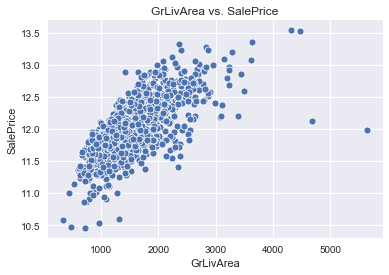

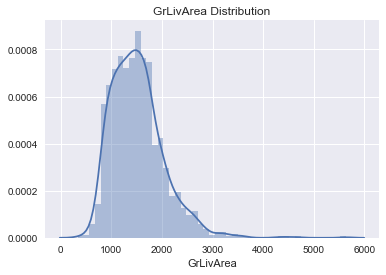

<Figure size 432x288 with 0 Axes>

In [11]:
cont_inspect(train, 'GrLivArea')

#### Drop Columns: First Pass

After inspecting each of the features using the methodology and visualizations described above, I decided to drop the following features to simplify the dataframe and make my analysis simpler.

In [12]:
to_drop = ['Heating','BldgType','Alley','Street',
           'Utilities','MSSubClass','LotFrontage','LotShape',
           'LandContour','Condition1','Condition2',
           'OverallCond','YearBuilt','YearRemodAdd','RoofMatl',
           'Exterior1st','Exterior2nd','MasVnrType','MasVnrArea',
           'ExterQual','Foundation','BsmtQual','BsmtFinSF1','BsmtCond',
           'BsmtFinType2','BsmtFinSF2','BsmtUnfSF','HeatingQC','Electrical',
           'LowQualFinSF','BsmtFullBath',
           'BsmtHalfBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
           'Functional','Fireplaces','FireplaceQu','GarageType',
           'GarageYrBlt','GarageFinish','GarageArea','GarageQual',
           'GarageCond','WoodDeckSF','OpenPorchSF','EnclosedPorch',
           '3SsnPorch','ScreenPorch','PoolArea','PoolQC','Fence',
           'MiscFeature','MiscVal','MoSold','YrSold','SaleType',
           'SaleCondition', 'LotArea', 'TotRmsAbvGrd', 'MSZoning',
           'LotConfig','LandSlope','ExterCond','BsmtExposure']

train = train.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

That brings us down to a much more reasonable size.  Next, we will do a more in-depth look at each of the features to get a better understanding of the transformations that need to take place before sending it to our algorithm.

### Step 3c. Fixing Nulls

Let's see if we have any columns with null values.  We will want to fill any null values prior to applying any transformations to our features

In [13]:
features = ['HouseStyle','OverallQual','TotalBsmtSF',
            'GrLivArea','FullBath','KitchenQual','GarageCars','RoofStyle','BsmtFinType1',
           'PavedDrive','CentralAir','1stFlrSF','2ndFlrSF','Neighborhood']

In [14]:
for feature in features:
    if train[feature].isnull().sum().sum()>0:
        print("Train / {0}: {1} nulls".format(feature, train[feature].isnull().sum().sum()))
    if test[feature].isnull().sum().sum()>0:
        print("Test / {0}: {1} nulls".format(feature, test[feature].isnull().sum().sum()))

Test / TotalBsmtSF: 1 nulls
Test / KitchenQual: 1 nulls
Test / GarageCars: 1 nulls
Train / BsmtFinType1: 37 nulls
Test / BsmtFinType1: 42 nulls


##### Test / TotalBsmtSF

In [15]:
test_original[test_original['TotalBsmtSF'].isnull()] # I am using test_original here to get more context.

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
660,2121,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml


Let's change the value to '0' because it looks like they don't have a basement

In [16]:
test.TotalBsmtSF.fillna(0, inplace=True)

Let's also combine all interior "SF" measurements into one, then drop the component features:

In [17]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

sf_drop = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea'] # note: I also drop "GrLivArea" because it is redundant now.

train = train.drop(sf_drop, axis=1)
test = test.drop(sf_drop, axis=1)

##### Test / KitchenQual

In [18]:
test_original[test_original['KitchenQual'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
95,1556,50,RL,72.0,10632,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1.5Fin,5,3,1917,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,Fa,No,Unf,0.0,Unf,0.0,689.0,689.0,GasA,Gd,N,SBrkr,725,499,0,1224,0.0,0.0,1,1,3,1,NaN,6,Mod,0,NaN,Detchd,1917.0,Unf,1.0,180.0,Fa,Fa,N,0,0,248,0,0,0,NaN,NaN,NaN,0,1,2010,COD,Normal


I'm going to assume that because their basement quality is "Good", that perhaps their kitchen is as well.

In [19]:
test.KitchenQual.fillna('Gd', inplace=True)

##### Test / GarageCars

In [20]:
test_original[test_original['GarageCars'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1116,2577,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca


In [21]:
test_original['GarageCars'].value_counts()

2.0    770
1.0    407
3.0    193
0.0     76
4.0     11
5.0      1
Name: GarageCars, dtype: int64

Let's go with the mode of 2.0.

In [22]:
test.GarageCars.fillna(2.0, inplace=True)

##### Train / BsmtFinType1

The data documentation mentions that 'NA' means 'No Basement', not NaN (as Pandas is interpreting it).  Let's fix that:

In [23]:
train.BsmtFinType1.fillna('NoBase', inplace=True)

##### Test / BsmtFinType1

In [24]:
test.BsmtFinType1.fillna('NoBase', inplace=True)

### Step 3d. Fix outliers in train set & apply log transformations to continuous variables

<strong>Note:</strong> I am visually inspecting for outliers. Please note that you can also use statistical methods (best practice) to detect outliers, but that is outside the scope of this notebook.

##### TotalBsmtSF

Number of NaNs: 0


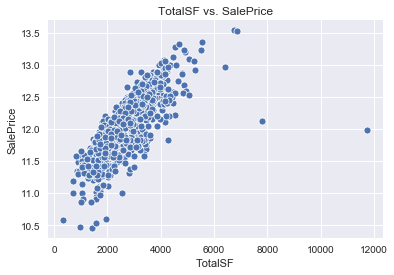

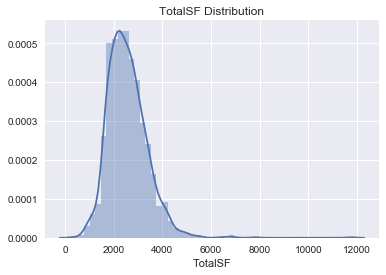

<Figure size 432x288 with 0 Axes>

In [25]:
cont_inspect(train, 'TotalSF')

In [26]:
# drop the two values that are outliers
train = train.drop(train[(train['TotalSF']>7000)].index)

Now that I dropped that outlier, I am going to apply the log1p function to this series to help normalize the distribution.

In [27]:
train['TotalSF'] = np.log1p(train['TotalSF'])
test['TotalSF'] = np.log1p(test['TotalSF'])

Let's see the results:

Number of NaNs: 0


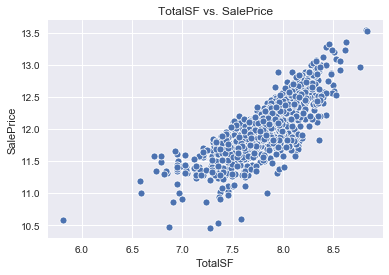

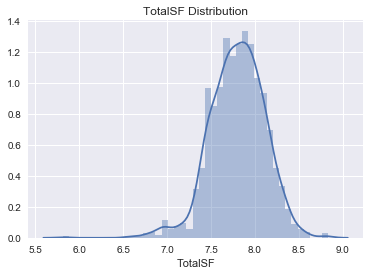

<Figure size 432x288 with 0 Axes>

In [28]:
cont_inspect(train, 'TotalSF')

### Step 3e. (Optional) Visualize your numerical features

Let's see how our numerical features correlate with a heat map.

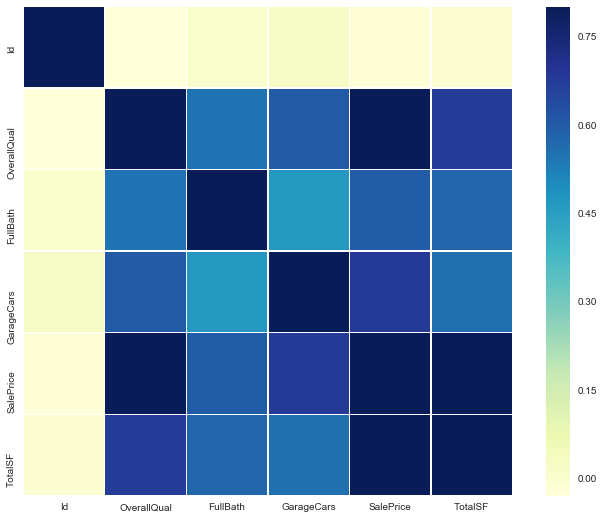

In [29]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, linewidths=.5, cmap="YlGnBu");

Looks good.

### Step 3f. Feature Encoding

#### Concatenate the train and test DataFrames

We do this to ensure that our columns are the same between our train and test DataFrames after we transform the columns.

In [30]:
print("Train shape: {0}".format(train.shape))
print("Test shape: {0}".format(test.shape))

Train shape: (1458, 13)
Test shape: (1459, 12)


Let's add a "dummy" column to test and concatenate the two datasets.

In [31]:
test['SalePrice'] = -1

In [32]:
print("Train shape: {0}".format(train.shape))
print("Test shape: {0}".format(test.shape))

Train shape: (1458, 13)
Test shape: (1459, 13)


In [33]:
data = pd.concat([train, test])

#### Transformations

##### BsmtFinType1, CentralAir, HouseStyle, KitchenQual, RoofStyle, PavedDrive

We use Panda's get_dummies method, which will encode our categorical values into binary values.

In [34]:
get_dummies_cats = ['BsmtFinType1', 'CentralAir', 'HouseStyle', 'KitchenQual', 'RoofStyle', 'PavedDrive', 'Neighborhood']

data = pd.get_dummies(data, columns=get_dummies_cats) # Apply feature encoding to the concatenated DataFrame!

Export our processed data:

In [35]:
data.to_csv("../data/processed/data_processed.csv")

## Step 4: Modeling

### Imports for modeling

In [36]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

### Re-split data

In [37]:
# First, split the data into the train and test sets again, keeping all columns.
data_train = data.iloc[:1458]
data_test = data.iloc[1458:]

# Second, drop the dummy 'SalePrice' column from data_test.
data_test = data_test.drop(['SalePrice'], axis=1)

# Third, split our training data into 'features' (X) and 'labels' (y) so that we can test.
X = np.array(data_train.drop(['SalePrice'],1)) # Just the features!
y = np.array(data_train['SalePrice']) # Just the SalePrice (target) column!

#X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

### See which models might work best using cross validation

In [38]:
# instantiate a few models
lin_reg = LinearRegression()
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=3))


def score_model_with_cv(n_folds, model):
    kf = KFold(n_folds, shuffle=True, random_state=14).get_n_splits(X)
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf)
    rmse_scores = np.sqrt(-scores)
    for i in range(len(rmse_scores)):
        print('#{0} fold: {1}'.format(i + 1, rmse_scores[i]))

In [39]:
models = [lin_reg, ENet, lasso]

for model in models:
    score_model_with_cv(5, model)
    print('-')

#1 fold: 0.13716773128383408
#2 fold: 0.14601856776041877
#3 fold: 0.14811846628787634
#4 fold: 0.1364393425782993
#5 fold: 0.13067162350011688
-
#1 fold: 0.13737879258864585
#2 fold: 0.14733018837365916
#3 fold: 0.14677096564376066
#4 fold: 0.1375648256272924
#5 fold: 0.12916498452734262
-
#1 fold: 0.13757507949035186
#2 fold: 0.14759756516546393
#3 fold: 0.1468863351896956
#4 fold: 0.13784672399582587
#5 fold: 0.12922674709953125
-


Let's go with the Elastic Net model.

### Predict 'SalePrice' for the test set.

In [40]:
ENet.fit(X, y) # train
predictions = np.expm1(ENet.predict(data_test)) # predict
predictions # see predictions

array([112010.49649718, 170357.34138709, 170858.58317029, ...,
       146472.80896076, 115158.41108668, 203940.56291286])

In [41]:
# add our predictions to the data_test DataFrame.
data_test['SalePrice'] = predictions

In [42]:
# Take just Id and SalePrice and convert our DataFrame into a .csv file for submission.
data_test[['Id', 'SalePrice']].to_csv('Ames_submission.csv', index=False)